In [1]:
import sys
sys.path.append('..')
from dataloader.datamodule_ecog2hb import ECoGPhonemeDataModule
import numpy as np
import torch
from streaming.streamer import Streamer
import time
import tqdm
import torchaudio
import matplotlib.pyplot as plt

/home/cheoljun/anaconda3/envs/rnnt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
streamer = Streamer(rnnt_ckpt_path='../outputs/2023-10-10/03-27-29/hubert-l6_km100_nocollapse-causal_tm1k',
                    vocoder_ckpt_path="/data/vocoder_ckpts/lj_hub_u2w_vctk_6-100_embed_short/best_mel_ckpt.pkl",
                    buffer_size=32, beam_width=20, input_sr=200,
                 audio_sr=16000, enc_q=4, vocab_size=100, step_max_tokens=50,
                 best_n=1, device='cuda:2', sil_id=56,rnnt_load='best')

Loaded model parameters from /data/vocoder_ckpts/lj_hub_u2w_vctk_6-100_embed_short/best_mel_ckpt.pkl.


In [3]:
datamodule = ECoGPhonemeDataModule(**streamer.rnnt_cfg['data'])

In [4]:
test_loader = datamodule.test_dataloader()

In [5]:
test_loader.dataset.transform=None

In [6]:
streamer.prev_wavs_.shape

torch.Size([1, 1, 512])

In [7]:
times = []
rnnt_times =[]
unitexpand_times=[]
vocoder_times=[]
buffer_size = streamer.buffer_size
for i in tqdm.tqdm(range(len(test_loader.dataset))):
    x = test_loader.dataset.__getitem__(i)
    input_all = x['ecog']
    wavs=[]
    rnnt_times =[]
    unitexpand_times=[]
    vocoder_times=[]
    streamer.clear_cache()
    for i in range(0,int(x['ecog_len']//buffer_size*buffer_size),buffer_size):
        start_time = time.time()
        x = input_all[i:i+buffer_size]
        wav, (rnnt_time, unitexpand_time, vocoder_time) = streamer(x, break_time=True)
        wavs.append(wav)
        end_time = time.time()
        times.append(end_time-start_time)
        rnnt_times.append(rnnt_time)
        unitexpand_times.append(unitexpand_time)
        vocoder_times.append(vocoder_time)
    wavs = np.concatenate(wavs)
    break

  0%|                                                   | 0/250 [00:47<?, ?it/s]


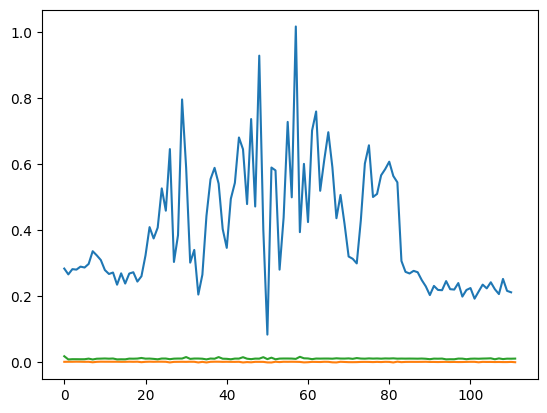

In [14]:
plt.plot(rnnt_times[1:])
plt.plot(unitexpand_times)
plt.plot(vocoder_times)

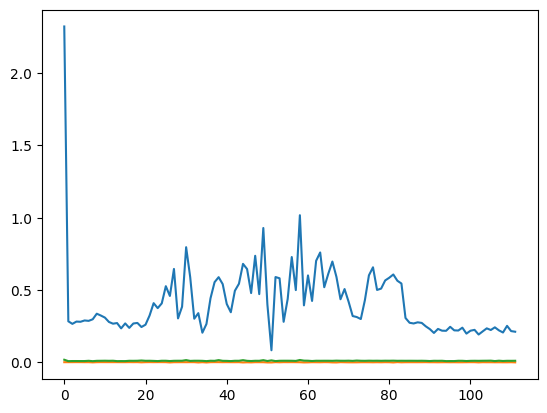

In [15]:
plt.plot(rnnt_times)
plt.plot(unitexpand_times)
plt.plot(vocoder_times)

In [16]:
import IPython.display as ipd

In [17]:
ipd.display(ipd.Audio(wavs, rate=16000))